In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import os
import gc
import re
import json
import shutil
import zipfile
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry.polygon import orient
from shapely.geometry import Polygon, mapping
from xml.etree import ElementTree as ET
from icelakes.utilities import get_size

from icelakes.utilities import encedc, decedc, get_size
from icelakes.nsidc import download_granule, edc
from icelakes.detection import read_atl03, detect_lakes, melt_lake

import time
import io

In [415]:
################################################################################
def plot_geojsons_for_query(searchfor, gjsn_dir='geojsons'):
    dpi = 100
    if 'ANT_' in searchfor:
        dpi = 300
    fig, ax = plt.subplots(dpi=dpi)
    gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
                if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
    for i, gjsn in enumerate(gjsn_list):
        gdf = gpd.read_file(gjsn.replace('simplified_', ''))
        gdf.plot(color='C%i' % i, alpha=0.2, ax=ax)
        gdf.exterior.plot(color='r', lw=0.5, ax=ax)
        gdf = gpd.read_file(gjsn)
        gdf.exterior.plot(color='k', lw=0.5, ax=ax)
    ax.set_title('geojsons used for: %s' % searchfor)
    plt.close(fig)
    display(fig)
    return fig

################################################################################
def make_async_request(short_name='ATL03', start_date='2018-01-01', end_date='2030-01-01', uid=None, pwd=None, rgt='all', gtxs='all',
                       boundbox=None, shape=None, vars_sub='default', output_dir='nsidc_outputs', start_time='00:00:00', end_time='23:59:59',
                       spatial_sub=True):

    if (not uid) or (not pwd):
        uid = decedc(edc().u)
        pwd = decedc(edc().p)
    
    bounding_box = '' if not boundbox else '%.7f,%.7f,%.7f,%.7f' % tuple(boundbox)
    temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
    
    cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
    granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'
    base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'
    
    # Get json response from CMR collection metadata
    params = {'short_name': short_name}
    response = requests.get(cmr_collections_url, params=params)
    results = json.loads(response.content)
    
    # Find all instances of 'version_id' in metadata and print most recent version number
    versions = [el['version_id'] for el in results['feed']['entry']]
    latest_version = max(versions)
    capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'
    
    search_params = {'short_name': short_name, 'version': latest_version, 'temporal': temporal, 'page_size': 2000, 'page_num': 1}
    if boundbox is not None: search_params['bounding_box'] = bounding_box
    elif shape is not None: 
        geojson_filepath = str('geojsons/' + shape)
        gdf = gpd.read_file(geojson_filepath)
        poly = orient(gdf.loc[0].geometry,sign=1.0)
        geojson_data = gpd.GeoSeries(poly).to_json() # Convert to geojson
        geojson_data = geojson_data.replace(' ', '') #remove spaces for API call
        
        #Format dictionary to polygon coordinate pairs for CMR polygon filtering
        polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
        
        print('\nInput geojson:', shape)
        print('Simplified polygon coordinates based on geojson input:', polygon)
        search_params['polygon'] = polygon
        
    else: print('No spatial filtering criteria were given.')
    
    headers= {'Accept': 'application/json'}
    print("Search parameters:", search_params)
    
    # query for granules 
    granules = []
    headers={'Accept': 'application/json'}
    while True:
        response = requests.get(granule_search_url, params=search_params, headers=headers)
        results = json.loads(response.content)
        if len(results['feed']['entry']) == 0: break
        granules.extend(results['feed']['entry'])
        search_params['page_num'] += 1
        
    if not (rgt=='all'):
        granules = [g for g in granules if g['producer_granule_id'][21:25] == '%04i'%rgt]
        
    granule_list, idx_unique = np.unique(np.array([g['producer_granule_id'] for g in granules]), return_index=True)
    granules = [g for i,g in enumerate(granules) if i in idx_unique]
    
    print('\nFound %i %s version %s granules over the search area between %s and %s.' % (len(granules), short_name, latest_version, 
                                                                              start_date, end_date))
    if len(granules) == 0: print('None')
    for result in granules[:np.min((5,len(granules)))]:
        print('  '+result['producer_granule_id'], f', {float(result["granule_size"]):.2f} MB',sep='')
    if len(granules) > 5:
        print('  ...and %i more results.' % (len(granules)-5))
    
    # Create session to store cookie and pass credentials to capabilities url
    session = requests.session()
    s = session.get(capability_url)
    response = session.get(s.url,auth=(uid,pwd))
    
    root = ET.fromstring(response.content)
    
    #collect lists with each service option
    subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]
    
    # this is for getting possible variable values from the granule search
    if len(subagent) > 0 :
        # variable subsetting
        variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
        variables_raw = [variables[i]['value'] for i in range(len(variables))]
        variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
        variable_vals = [v.replace(':', '/') for v in variables_join]
    
    # make sure to only request the variables that are available
    def intersection(lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3
    
    # set the variables for subsetting
    if vars_sub == 'all':
        var_list_subsetting = ''
    else:
        if vars_sub == 'default':
            vars_sub = ['/ancillary_data/atlas_sdp_gps_epoch',
                        '/ancillary_data/calibrations/dead_time/gtx',
                        '/orbit_info/rgt',
                        '/orbit_info/cycle_number',
                        '/orbit_info/sc_orient',
                        '/gtx/geolocation/segment_id',
                        '/gtx/geolocation/ph_index_beg',
                        '/gtx/geolocation/segment_dist_x',
                        '/gtx/geolocation/segment_length',
                        '/gtx/geolocation/segment_ph_cnt',
                        '/gtx/geophys_corr/geoid',
                        '/gtx/bckgrd_atlas/pce_mframe_cnt',
                        '/gtx/bckgrd_atlas/tlm_height_band1',
                        '/gtx/bckgrd_atlas/tlm_height_band2',
                        '/gtx/bckgrd_atlas/tlm_top_band1',
                        '/gtx/bckgrd_atlas/tlm_top_band2',
                        '/gtx/heights/lat_ph',
                        '/gtx/heights/lon_ph',
                        '/gtx/heights/h_ph',
                        '/gtx/heights/delta_time',
                        '/gtx/heights/dist_ph_along',
                        '/gtx/heights/quality_ph',
                        '/gtx/heights/pce_mframe_cnt',
                        '/gtx/heights/ph_id_pulse'
                        ]
        beam_list = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
        if gtxs == 'all':
            var_list = sum([[v.replace('/gtx','/'+bm) for bm in beam_list] if '/gtx' in v else [v] for v in vars_sub],[])
        elif type(gtxs) == str:
            var_list = [v.replace('/gtx','/'+gtxs.lower()) if '/gtx' in v else v for v in vars_sub]
        elif type(gtxs) == list:
            var_list = sum([[v.replace('/gtx','/'+bm.lower()) for bm in gtxs] if '/gtx' in v else [v] for v in vars_sub],[])
        else: # default to requesting all beams
            var_list = sum([[v.replace('/gtx','/'+bm) for bm in beam_list] if '/gtx' in v else [v] for v in vars_sub],[])
        var_list_subsetting = ','.join(var_list)
    
    # set the request parameters
    if len(subagent) < 1 :
        print('No services exist for', short_name, 'version', latest_version)
        agent = 'NO'
        coverage,Boundingshape,polygon = '','',''
    else:
        agent = ''
        subdict = subagent[0]
        if (subdict['spatialSubsettingShapefile'] == 'true') and spatial_sub:
            if shape:
                Boundingshape, bbox, bounding_box = polygon, '', ''
            else:
                Boundingshape, polygon = '', ''
        else:
            Boundingshape, polygon = '',''
        coverage = var_list_subsetting
    if (vars_sub=='all') & (not spatial_sub):
        agent = 'NO'
    
    # Set request mode to asynchronous
    request_mode = 'async'
    page_size = 2000
    # Determine number of orders needed for requests over 2000 granules. 
    page_num = int(np.ceil(len(granules)/page_size))
    
    print('  --> There will be', page_num, 'total order(s) processed for your', short_name, 'request.')
    param_dict = {'short_name': short_name, 
                  'version': latest_version, 
                  'temporal': temporal, 
                  'bbox': bbox,
                  'bounding_box': bounding_box,
                  'Boundingshape': Boundingshape, 
                  'polygon': polygon,
                  'Coverage': coverage, 
                  'page_size': page_size, 
                  'request_mode': request_mode, 
                  'agent': agent, 
                  'email': 'no', }
    
    # Remove blank key-value-pairs
    param_dict = {k: v for k, v in param_dict.items() if v != ''}
    
    # Convert to string
    param_string = '&'.join("{!s}={!r}".format(k,v) for (k,v) in param_dict.items())
    param_string = param_string.replace("'","")
    
    # Print API base URL + request parameters
    endpoint_list = [] 
    for i in range(page_num):
        page_val = i + 1
        API_request = f'{base_url}?{param_string}&page_num={page_val}'
        endpoint_list.append(API_request)
    
    print('\n', *endpoint_list, sep = "\n") 
    
    for i in range(page_num):
        page_val = i + 1
        print('Order: ', page_val)
    
        # For all requests other than spatial file upload, use get function
        param_dict['page_num'] = page_val
        request = session.get(base_url, params=param_dict)
    
        print('Request HTTP response: ', request.status_code)
    
        # Raise bad request: Loop will stop for bad response code.
        request.raise_for_status()
        # print('Order request URL: ', request.url)
        esir_root = ET.fromstring(request.content)
        # print('Order request response XML content: ', request.content)
    
        #Look up order ID
        orderlist = []   
        for order in esir_root.findall("./order/"):
            orderlist.append(order.text)
        orderID = orderlist[0]
        print('order ID: ', orderID)
    
        #Create status URL
        statusURL = base_url + '/' + orderID
        print('status URL: ', statusURL)
    
        #Find order status
        request_response = session.get(statusURL)    
        print('HTTP response from order response URL: ', request_response.status_code)
    
        # Raise bad request: Loop will stop for bad response code.
        request_response.raise_for_status()
        request_root = ET.fromstring(request_response.content)
        statuslist = []
        for status in request_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Data request ', page_val, ' is submitting...')
        print('Initial request status is ', status)
    
    return statusURL, len(granules), request_response.status_code


def filter_release(df_in):
    # there should not be any, but to make sure drop any duplicates
    df = df_in.copy()
    df = df.drop_duplicates(ignore_index=True)
    
    # keep only the latest release of each granule (relevant during ITRF reprocessing, etc.)
    df['release'] = df.apply(lambda x: int(x.granule.split('_')[-1][:2]), axis=1)
    df['version'] = df.apply(lambda x: int(x.granule.split('_')[3]), axis=1)
    df['ttttccnn'] = df.apply(lambda x: int(x.granule.split('_')[2]), axis=1)
    
    # make id for granule / region combination
    df['granule_region_id'] = df.apply(lambda x: str(x.ttttccnn) + x.geojson_clip, axis=1)
    df_maxversion = df.groupby(by='granule_region_id')[['version']].max().rename(columns={'version': 'version_max'})
    df['select'] = df.apply(lambda x: x.version == df_maxversion.loc[x.granule_region_id].version_max, axis=1)
    df = df[df.select]
    df_maxrelease = df.groupby(by='granule_region_id')[['release']].max().rename(columns={'release': 'release_max'})
    df['select'] = df.apply(lambda x: x.release == df_maxrelease.loc[x.granule_region_id].release_max, axis=1)
    df = df[df.select]

    return df


def write_granule_list(input_list):
    df = pd.read_csv(input_list, header=None, names=['fn','hold_reason'])
    df['is_memory'] = df.apply(lambda x: 'exceeded request_memory' in x.hold_reason, axis=1)
    df['granule'] = df.apply(lambda x: x.fn[x.fn.find('ATL03_'):x.fn.find('.h5')+3], axis=1)
    def get_description(x):
        substr = x.fn[x.fn.find('job_')+4:x.fn.find('_ATL03_')]
        return substr[:substr.rfind('-')]
    df['description'] = df.apply(get_description, axis=1)
    def get_geojson(x):
        parms = x.description.split('_')
        parms[0] = 'ANT' if parms[0] == 'AIS' else 'GRE'
        del parms[1]
        return 'geojsons/simplified_' + '_'.join(parms) + '.geojson'
    df['geojson'] = df.apply(get_geojson, axis=1)
    df['geojson_full'] = df.apply(lambda x: x.geojson.replace('simplified_', ''), axis=1)
    df = df[['granule','geojson','description','geojson_full','fn','hold_reason','is_memory']]
    df.to_csv(input_list.replace('.csv', '_processed.csv'))
    
    df_mem = df[df.is_memory]
    df_nomem = df[~df.is_memory]
    
    df_mem = df_mem.drop(columns=['fn','hold_reason','is_memory'])
    df_nomem = df_nomem.drop(columns=['fn','hold_reason','is_memory'])
    
    fn_mem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'memory_')
    fn_nomem = input_list.replace('hold_lists/', 'granule_lists/').replace('final_', 'resubmit_')
    
    df_mem.to_csv(fn_mem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_mem, len(df_mem)))
    df_nomem.to_csv(fn_nomem, header=False, index=False)
    print('Wrote file %s. (%i jobs)' % (fn_nomem, len(df_nomem)))

    return fn_mem, fn_nomem


def write_submit_file(list_fn, sub_fn=None, mem_gb=16, resource_adjust=False, stream_error=False, stream_output=False): 
    if not sub_fn:
        sub_fn = list_fn.replace('granule_lists/', 'HTCondor_submit/').replace('.csv', '.submit')
    
    f = open(sub_fn, "w")
    print('universe    = vanilla', file=f)
    print('+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"', file=f)
    print('Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000', file=f)
    print('executable  = run_py.sh', file=f)
    print('arguments = $(granule_url) $(polygon)', file=f)
    print('max_retries = 30', file=f)
    print('success_exit_code = 69', file=f)
    print('transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)', file=f)
    print('transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat', file=f)
    print('should_transfer_files = YES', file=f)
    print('when_to_transfer_output = ON_EXIT', file=f)
    print('periodic_release = (HoldReasonCode == 13)', file=f)
    print('log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log', file=f)
    print('error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err', file=f)
    print('output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out', file=f)
    if stream_error:
        print('stream_error = True', file=f)
    if stream_output:
        print('stream_output = True', file=f)
    print('request_cpus    = 1', file=f)
    if resource_adjust:
        print('request_memory  = $(mem_request)', file=f)
        print('request_disk    = $(dsk_request)', file=f)
        print('queue granule_url,granule_id,polygon,descriptor,polygon_full,mem_request,dsk_request from %s' % list_fn, file=f)
    else:
        print('request_memory  = %iGB' % mem_gb, file=f)
        print('request_disk    = %iGB' % mem_gb, file=f)
        print('queue granule_url,granule_id,polygon,descriptor,polygon_full from %s' % list_fn, file=f)
    f.close()
    
    print('Wrote file %s.\n' % sub_fn)
    return sub_fn


# Run the following to initialize the dataframe with NSIDC requests parameters

____________________________________________________________________________
GREENLAND 2019-23
____________________________________________________________________________


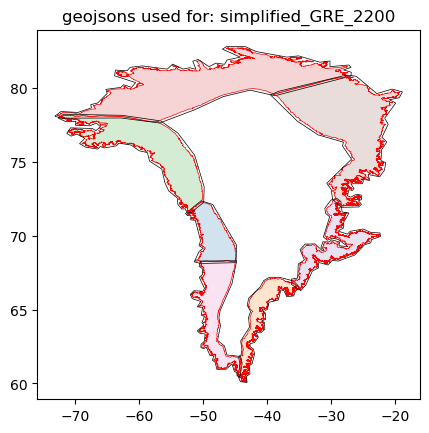

____________________________________________________________________________
ANTARCTICA - GLD3 (2018-19 to 2022-23)
____________________________________________________________________________


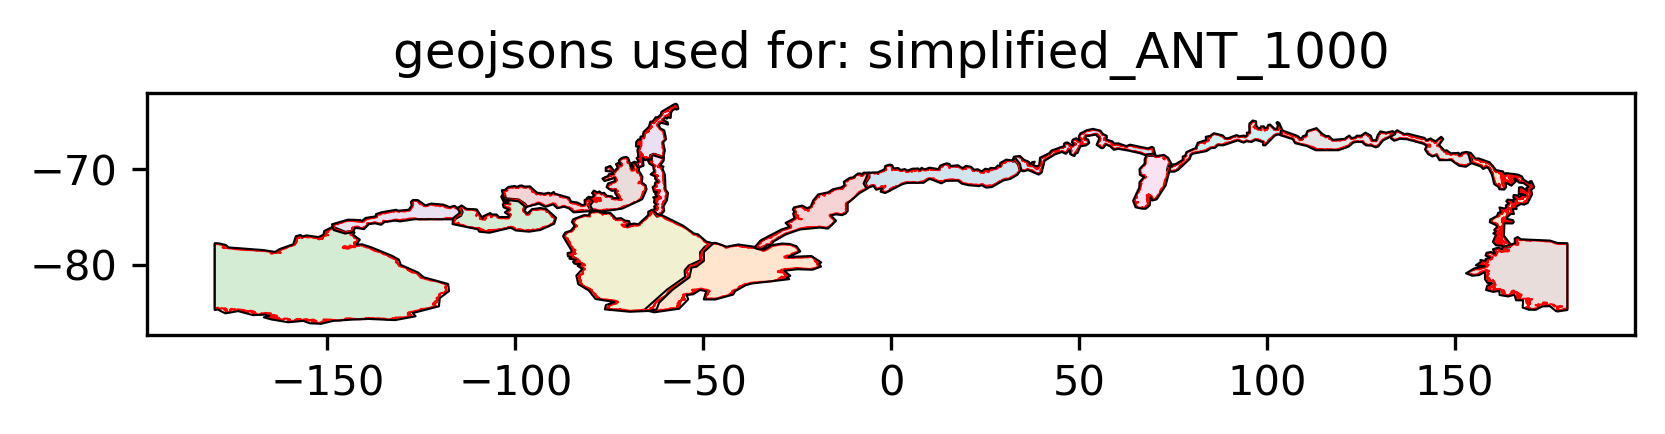

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,ngranules_request,request_code
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,-1,-1,-1
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,-1,-1,-1
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,-1,-1,-1
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,-1,-1,-1
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,-1,-1,-1
...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,-1,-1,-1
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,-1,-1,-1
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,-1,-1,-1
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,-1,-1,-1


In [11]:
outdict = {
    'ice_sheet': [],
    'melt_season': [],
    'geojson': [],
    'start_date': [],
    'end_date': []
}

############################################################
# GREENLAND - GLD3
startyear = 2019
endyear = 2023
startday = '05-01'
endday = '09-30'
icesheet = 'GrIS'

searchfor = 'simplified_GRE_2200'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('GREENLAND 2019-23')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    for yr in np.arange(startyear, endyear+1):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outdict['ice_sheet'].append(icesheet)
        outdict['melt_season'].append(meltseason)
        outdict['geojson'].append(geojson)
        outdict['start_date'].append(start_date)
        outdict['end_date'].append(end_date)

############################################################
# ANTARCTICA - GLD3
startyear = 2018
endyear = 2023
startday = '11-01'
endday = '03-31'
icesheet = 'AIS'

searchfor = 'simplified_ANT_1000'
gjsn_dir = 'geojsons'
gjsn_list = [gjsn_dir+'/'+f for f in os.listdir(gjsn_dir) \
            if os.path.isfile(os.path.join(gjsn_dir, f)) & (searchfor in f)]
print('____________________________________________________________________________')
print('ANTARCTICA - GLD3 (2018-19 to 2022-23)')
print('____________________________________________________________________________')

fig = plot_geojsons_for_query(searchfor, gjsn_dir='geojsons')
fig.savefig('basins/plots/query_geojsons_%s.jpg' % searchfor, dpi=300)

dflist = []
for i, gjsn in enumerate(gjsn_list):
    geojson = gjsn[gjsn.rfind('/')+1:]
    for yr in np.arange(startyear, endyear):
        start_date = '%s-%s' % (yr, startday)
        end_date = '%s-%s' % (yr+1, endday)
        meltseason = start_date[:4] if start_date[:4]==end_date[:4] else start_date[:4] + '-' + end_date[2:4]
        outdict['ice_sheet'].append(icesheet)
        outdict['melt_season'].append(meltseason)
        outdict['geojson'].append(geojson)
        outdict['start_date'].append(start_date)
        outdict['end_date'].append(end_date)

df = pd.DataFrame(outdict)

df['status_url'] = -1
df['ngranules_request'] = -1
df['request_code'] = -1

fn_requests = 'nsidc_requests/gld3_request_params.csv'
df.to_csv(fn_requests, header=True, index=False)

df = pd.read_csv(fn_requests)
df

# Run the following until all requests have been submitted 

In [224]:
fn_working = 'nsidc_requests/gld3_status_urls_working.csv'
if os.path.isfile(fn_working):
    df = pd.read_csv(fn_working)
else:
    df = pd.read_csv(fn_requests)

for i in list(df.index):
    row = df.loc[i]
    shape = row.geojson
    start_date = row.start_date
    end_date = row.end_date
    ice_sheet = row.ice_sheet
    melt_season = row.melt_season
    status_url = row.status_url
    if status_url != '-1':
        print('already submitted', ice_sheet, melt_season, shape, '(', i+1, '/', len(df), ')')
    else:
        print('\n________________________________________________________________________________')
        print('submitting', ice_sheet, melt_season, shape, '(', i+1, '/', len(df), ')')
        
        status_url, ngranules, status_code = make_async_request(short_name='ATL03', start_date=start_date, end_date=end_date, shape=shape)

        df.loc[i, 'status_url'] = status_url
        df.loc[i, 'request_code'] = status_code
        df.loc[i, 'ngranules_request'] = ngranules
        
        print('\n________________________________________________________________________________')

df.to_csv(fn_working, header=True, index=False)

df = pd.read_csv(fn_statusurls)
df

already processed GrIS 2019 simplified_GRE_2200_CW.geojson ( 1 / 125 )
already processed GrIS 2020 simplified_GRE_2200_CW.geojson ( 2 / 125 )
already processed GrIS 2021 simplified_GRE_2200_CW.geojson ( 3 / 125 )
already processed GrIS 2022 simplified_GRE_2200_CW.geojson ( 4 / 125 )
already processed GrIS 2023 simplified_GRE_2200_CW.geojson ( 5 / 125 )
already processed GrIS 2019 simplified_GRE_2200_SE.geojson ( 6 / 125 )
already processed GrIS 2020 simplified_GRE_2200_SE.geojson ( 7 / 125 )
already processed GrIS 2021 simplified_GRE_2200_SE.geojson ( 8 / 125 )
already processed GrIS 2022 simplified_GRE_2200_SE.geojson ( 9 / 125 )
already processed GrIS 2023 simplified_GRE_2200_SE.geojson ( 10 / 125 )
already processed GrIS 2019 simplified_GRE_2200_NW.geojson ( 11 / 125 )
already processed GrIS 2020 simplified_GRE_2200_NW.geojson ( 12 / 125 )
already processed GrIS 2021 simplified_GRE_2200_NW.geojson ( 13 / 125 )
already processed GrIS 2022 simplified_GRE_2200_NW.geojson ( 14 / 125 )
a

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,request_code,ngranules_request
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,98
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,110
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,108
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,109
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,107
...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,378
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,398
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,385
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,390


# Make sure all requests have an initial 201 status code

In [225]:
np.unique(df.request_code)

array([201])

In [226]:
# total number of granules
df.ngranules_request.sum()

54056

# Now run the following to get the info from the status URLs and run this until all requests at NSIDC have completed

In [421]:
df = pd.read_csv(fn_statusurls)

# #### to get the credentials into the session
# uid = decedc(edc().u)
# pwd = decedc(edc().p)
# capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
# session = requests.session()
# s = session.get(capability_url)
# response = session.get(s.url,auth=(uid,pwd))

df['description'] = df.apply(lambda x: '%s_%s_%s' % (x.ice_sheet, x.melt_season, '_'.join(x.geojson.split('_')[2:]).replace('.geojson','')), axis=1)
df['basin'] = df.apply(lambda x: '_'.join(x.description.split('_')[3:]), axis=1)
df['status'] = ''
df['orderID'] = ''
df['status_txt'] = -1
df['nprocessed'] = 0
df['n_links'] = 0
df['gran_list_url'] = ''
df['order_overview_url'] = ''
df['order_summary_url'] = ''
df['available_until'] = ''

for i in list(df.index):
    n_links = 0
    status_txt = -1
    gran_list_url = ''
    order_overview_url = ''
    order_summary_url = ''
    
    statusURL = df.loc[i,'status_url']
    
    #Find order status
    request_response = session.get(statusURL)
    status_code = request_response.status_code

    # Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    nprocessed = int(statuslist[1])
    
    orderlist = []
    for order in request_root.findall("./order/"):
        orderlist.append(order.text)
    instructions = orderlist[1]
    orderID = orderlist[0]
    available_until = instructions[instructions.rfind('URLs until ')+len('URLs until '):-7] if 'You may retrieve the results' in instructions else 'not yet available'

    if (status == 'complete') or (status == 'complete_with_errors'):
        order_overview_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s.html' % orderID
        gran_list_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s.txt' % orderID
        order_summary_url = 'https://n5eil02u.ecs.nsidc.org/esir/%s/requestSummary.txt' % orderID
        gran_list_file = session.get(gran_list_url)
        status_txt = int(gran_list_file.status_code)
        gran_list = gran_list_file.content.decode('utf-8').split('\n')
        gran_list = [x for x in gran_list if '.h5' in x]
        n_links = len(gran_list)

    df.loc[i, 'status'] = status
    df.loc[i, 'orderID'] = orderID
    df.loc[i, 'status_txt'] = status_txt
    df.loc[i, 'nprocessed'] = nprocessed
    df.loc[i, 'n_links'] = n_links
    df.loc[i, 'gran_list_url'] = gran_list_url
    df.loc[i, 'order_overview_url'] = order_overview_url
    df.loc[i, 'order_summary_url'] = order_summary_url
    df.loc[i, 'available_until'] = available_until

    print('%3i / %3i : %4s, %7s, %15s --> %s (%4i / %4i)' % (i+1, len(df), df.loc[i, 'ice_sheet'], df.loc[i, 'melt_season'], 
          df.loc[i, 'basin'], status, nprocessed, df.loc[i, 'ngranules_request']))

print('\n_____________________________________________________________________\n')
print('%.0f%% of granules processed at NSIDC (%i / %i)\n' % (df.nprocessed.sum() / df.ngranules_request.sum() * 100, df.nprocessed.sum(), df.ngranules_request.sum()))

fn_order_info_progress = 'nsidc_requests/gld3_order_info_complete.csv' if np.sum(df.status == 'complete') == len(df) else 'nsidc_requests/gld3_order_info_progress.csv'
df.to_csv(fn_order_info_progress, header=True, index=False)
df

  1 / 125 : GrIS,    2019,              CW --> complete (  98 /   98)
  2 / 125 : GrIS,    2020,              CW --> complete ( 110 /  110)
  3 / 125 : GrIS,    2021,              CW --> complete ( 108 /  108)
  4 / 125 : GrIS,    2022,              CW --> complete ( 109 /  109)
  5 / 125 : GrIS,    2023,              CW --> complete ( 107 /  107)
  6 / 125 : GrIS,    2019,              SE --> complete ( 116 /  116)
  7 / 125 : GrIS,    2020,              SE --> complete ( 134 /  134)
  8 / 125 : GrIS,    2021,              SE --> complete ( 133 /  133)
  9 / 125 : GrIS,    2022,              SE --> complete ( 133 /  133)
 10 / 125 : GrIS,    2023,              SE --> complete ( 130 /  130)
 11 / 125 : GrIS,    2019,              NW --> complete ( 276 /  276)
 12 / 125 : GrIS,    2020,              NW --> complete ( 305 /  305)
 13 / 125 : GrIS,    2021,              NW --> complete ( 300 /  300)
 14 / 125 : GrIS,    2022,              NW --> complete ( 303 /  303)
 15 / 125 : GrIS,   

,ice_sheet,melt_season,geojson,start_date,end_date,status_url,request_code,ngranules_request,description,basin,status,orderID,status_txt,nprocessed,n_links,gran_list_url,order_overview_url,order_summary_url,available_until
0,GrIS,2019,simplified_GRE_2200_CW.geojson,2019-05-01,2019-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,98,GrIS_2019_2200_CW,CW,complete,5000005624133,200,98,98,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:31
1,GrIS,2020,simplified_GRE_2200_CW.geojson,2020-05-01,2020-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,110,GrIS_2020_2200_CW,CW,complete,5000005624134,200,110,110,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:41
2,GrIS,2021,simplified_GRE_2200_CW.geojson,2021-05-01,2021-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,108,GrIS_2021_2200_CW,CW,complete,5000005624135,200,108,108,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 16:56
3,GrIS,2022,simplified_GRE_2200_CW.geojson,2022-05-01,2022-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,109,GrIS_2022_2200_CW,CW,complete,5000005624136,200,109,109,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 17:02
4,GrIS,2023,simplified_GRE_2200_CW.geojson,2023-05-01,2023-09-30,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,107,GrIS_2023_2200_CW,CW,complete,5000005624137,200,107,107,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,2024-07-01 17:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AIS,2018-19,simplified_ANT_1000_East_Cp-D.geojson,2018-11-01,2019-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,378,AIS_2018-19_1000_East_Cp-D,East_Cp-D,pending,5000005624282,-1,0,0,,,,not yet available
121,AIS,2019-20,simplified_ANT_1000_East_Cp-D.geojson,2019-11-01,2020-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,398,AIS_2019-20_1000_East_Cp-D,East_Cp-D,pending,5000005624283,-1,0,0,,,,not yet available
122,AIS,2020-21,simplified_ANT_1000_East_Cp-D.geojson,2020-11-01,2021-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,385,AIS_2020-21_1000_East_Cp-D,East_Cp-D,pending,5000005624284,-1,0,0,,,,not yet available
123,AIS,2021-22,simplified_ANT_1000_East_Cp-D.geojson,2021-11-01,2022-03-31,https://n5eil02u.ecs.nsidc.org/egi/request/500...,201,390,AIS_2021-22_1000_East_Cp-D,East_Cp-D,pending,5000005624285,-1,0,0,,,,not yet available


In [423]:
df.loc[26].order_overview_url

'https://n5eil02u.ecs.nsidc.org/esir/5000005624161.html'

# Now make the actual granule lists

In [251]:
outdir = 'granule_lists/'
outname = 'gld3test-GRE-CW-0.csv'
outpath = outdir + outname
df = pd.read_csv(fn_order_info_progress)
df_complete = df.iloc[:5]

# #### to get the credentials into the session
# uid = decedc(edc().u)
# pwd = decedc(edc().p)
# capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
# session = requests.session()
# s = session.get(capability_url)
# response = session.get(s.url,auth=(uid,pwd))

df_list = []
for i in list(df_complete.index):
    gran_list_url = df_complete.loc[i, 'gran_list_url']
    gran_list_file = session.get(gran_list_url)
    status_txt = int(gran_list_file.status_code)
    gran_list = gran_list_file.content.decode('utf-8').split('\n')
    gran_list = [x for x in gran_list if '.h5' in x]
    order_overview_url = df_complete.loc[i, 'order_overview_url']
    gran_list_html = session.get(order_overview_url)
    gran_list_html_txt = gran_list_html.content.decode('utf-8')
    starts = [m.end() for m in re.finditer(re.escape(".h5</a> ("), gran_list_html_txt)]
    ends = [m.start() for m in re.finditer(re.escape(", SCIENCE, content/unknown)"), gran_list_html_txt)]
    size_strs = [gran_list_html_txt[starts[j]:ends[j]] for j in range(len(starts))]
    sizes = [float(x[:-3].replace('<', '')) for x in size_strs]
    
    thisdf = pd.DataFrame({'granule_url': gran_list})
    thisdf['granule_id'] = thisdf.apply(lambda x: x.granule_url.split('/')[-1].replace('processed_','').replace('.h5',''), axis=1)
    thisdf['polygon'] = 'geojsons/' + df_complete.loc[i, 'geojson']
    thisdf['descriptor'] = df_complete.loc[i, 'description']
    thisdf['polygon_full'] = 'geojsons/' + df_complete.loc[i, 'geojson'].replace('simplified_', '')
    thisdf['size_mb'] = sizes
    df_list.append(thisdf)

df_all = pd.concat(df_list).reset_index(drop=True)
df_all.to_csv(outdir + 'size_' + outname, header=True, index=False)
df_all.iloc[:,:5].to_csv(outpath, header=False, index=False)

print('\nDataframe with all info:')
display(df_all)
print('\ntotal size: %.3g TB\n\n' % (df_all.size_mb.sum()/1e6))

df_granlist = pd.read_csv(outpath, header=None)
print('\nThe actual granule list for the job:')
display(df_granlist)

submit_filename = write_submit_file(outpath, mem_gb=8)
! cat $submit_filename


Dataframe with all info:


,granule_url,granule_id,polygon,descriptor,polygon_full,size_mb
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190916150733_12300405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,1209.51
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908023918_11000403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,9.26
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920145914_12910405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,630.88
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190904153231_10470405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,246.47
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920021420_12830403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,267.98
...,...,...,...,...,...,...
527,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230621213943_00262005_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson,412.73
528,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230630205719_01632005_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson,263.50
529,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230610213904_12451905_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson,13.80
530,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230613215623_12911905_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson,553.51



total size: 0.17 TB



The actual granule list for the job:


,0,1,2,3,4
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190916150733_12300405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908023918_11000403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920145914_12910405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190904153231_10470405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920021420_12830403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson
...,...,...,...,...,...
527,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230621213943_00262005_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson
528,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230630205719_01632005_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson
529,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230610213904_12451905_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson
530,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20230613215623_12911905_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2023_2200_CW,geojsons/GRE_2200_CW.geojson


Wrote file HTCondor_submit/gld3test-GRE-CW-0.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = 8GB
reque

In [425]:
testpath = 'granule_lists/resource_test.csv'
df_granlist = pd.read_csv(outdir + 'size_' + outname)
dftest = df_granlist.iloc[:7].copy()
mem = ['%iMB' % (1000*2**i) for i in range(1,8)]
dsk = ['%iKB' % (1000000*2**i) for i in range(1,8)]
dftest['mem_request'] = mem 
dftest['dsk_request'] = dsk
dftest.drop(columns=['size_mb']).to_csv(testpath, header=False, index=False)

df_ = pd.read_csv(testpath, header=None)
display(df_)

submit_filename = write_submit_file(testpath, resource_adjust=True)
! cat $submit_filename

,0,1,2,3,4,5,6
0,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190916150733_12300405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,2000MB,2000000KB
1,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908023918_11000403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,4000MB,4000000KB
2,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920145914_12910405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,8000MB,8000000KB
3,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190904153231_10470405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,16000MB,16000000KB
4,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190920021420_12830403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,32000MB,32000000KB
5,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190924020602_13440403_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,64000MB,64000000KB
6,https://n5eil02u.ecs.nsidc.org/esir/5000005624...,ATL03_20190908152412_11080405_006_02,geojsons/simplified_GRE_2200_CW.geojson,GrIS_2019_2200_CW,geojsons/GRE_2200_CW.geojson,128000MB,128000000KB


Wrote file HTCondor_submit/resource_test.submit.

universe    = vanilla
+SingularityImage = "osdf:///ospool/ap21/data/fliphilipp/containers/icelake-container_v1.sif"
Requirements = HAS_SINGULARITY == True && OSG_HOST_KERNEL_VERSION >= 31000
executable  = run_py.sh
arguments = $(granule_url) $(polygon)
max_retries = 30
success_exit_code = 69
transfer_input_files = detect_lakes.py, icelakes/__init__.py, icelakes/utilities.py, icelakes/nsidc.py, icelakes/detection.py, misc/test1, misc/test2, $(polygon), $(polygon_full)
transfer_output_files = detection_out_data, detection_out_plot, detection_out_stat
should_transfer_files = YES
when_to_transfer_output = ON_EXIT
periodic_release = (HoldReasonCode == 13)
log           = logs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).log
error         = errs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).err
output        = outs/job_$(descriptor)-$(ClusterID)_$(granule_id)-$(ProcID).out
request_cpus    = 1
request_memory  = $(mem_request

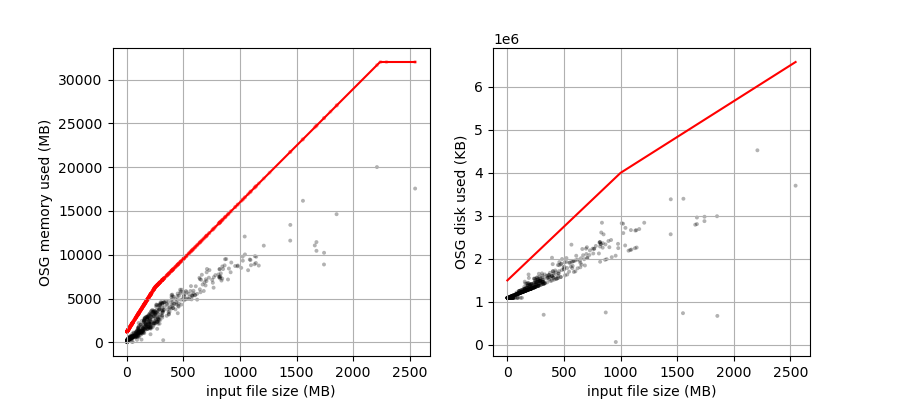

In [404]:
dfs = pd.read_csv(outdir + 'size_' + outname)
dfs['uniq'] = dfs.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfs = dfs.set_index('uniq')

dfm = pd.read_csv('resource_stats_memory.csv', names=['raw'])
def get_used_mem(x):
    words = x.raw[x.raw.find('Memory (MB)          :')+22:].split()
    return int(words[0]) if len(words) == 3 else np.nan
dfm['descriptor'] = dfm.apply(lambda x: x.raw[9:x.raw.find('-')], axis=1)
dfm['granule_id'] = dfm.apply(lambda x: x.raw[x.raw.find('_ATL03_')+1:x.raw.rfind('-')], axis=1)
dfm['mem_used_mb'] = dfm.apply(get_used_mem, axis=1)
dfm['uniq'] = dfm.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfm = dfm.groupby('uniq')[['mem_used_mb']].max()
dfmm = dfs.join(dfm, how='left')

dfd = pd.read_csv('resource_stats_disk.csv', names=['raw'])
def get_used_disk(x):
    words = x.raw[x.raw.find('Disk (KB)            :')+22:].split()
    return int(words[0]) if len(words) == 3 else np.nan
dfd['descriptor'] = dfd.apply(lambda x: x.raw[9:x.raw.find('-')], axis=1)
dfd['granule_id'] = dfd.apply(lambda x: x.raw[x.raw.find('_ATL03_')+1:x.raw.rfind('-')], axis=1)
dfd['disk_used_kb'] = dfd.apply(get_used_disk, axis=1)
dfd['uniq'] = dfd.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfd = dfd.groupby('uniq')[['disk_used_kb']].max()
dfdm = dfs.join(dfd, how='left')

def get_request_memory(x):
    req = 16000
    if x < 250:
        req = 1200 + (6300-1200) / 250 * x
    if x >= 250:
        req = 6300 + (16000-6300) / (1000 - 250) * (x - 250)
    return int(np.ceil(np.clip(req, 0, 32000)))

def get_request_disk(x):
    req = 8000
    if x < 1000:
        req = 1.5e6 + (4e6-1.5e6) / 1000 * x
    if x >= 1000:
        req = 4e6 + (6.5e6-4e6) / (2500 - 1000) * (x - 1000)
    return int(np.ceil(np.clip(req, 0, 32e6)))
    
dfmm['req'] = dfmm.size_mb.apply(get_request_memory)
dfdm['req'] = dfdm.size_mb.apply(get_request_disk)


fig, axs = plt.subplots(ncols=2, figsize=[9,4])

xvals = np.linspace(0, dfs.size_mb.max(), 500)
req_mem = [get_request_memory(x) for x in xvals]
req_disk = [get_request_disk(x) for x in xvals]

ax = axs[0]
ax.scatter(dfmm.size_mb, dfmm.mem_used_mb, s=8, color='k', edgecolors='none', alpha=0.3)
ax.scatter(dfmm.size_mb, dfmm.req, s=8, color='r', edgecolors='none', alpha=0.3)
ax.plot(xvals, req_mem, 'r-')
ax.grid()
ax.set_xlabel('input file size (MB)')
ax.set_ylabel('OSG memory used (MB)')

ax = axs[1]
ax.scatter(dfdm.size_mb, dfdm.disk_used_kb, s=8, color='k', edgecolors='none', alpha=0.3)
ax.plot(xvals, req_disk, 'r-')
ax.grid()
ax.set_xlabel('input file size (MB)')
ax.set_ylabel('OSG disk used (KB)')

fig.savefig('resource-usage_plots.jpg',dpi=300)

In [361]:
dfm.groupby('uniq')[['memory']].max()

,memory
uniq,
GrIS_2019_2200_CW-ATL03_20190502090550_05210303_006_02,259.0
GrIS_2019_2200_CW-ATL03_20190502215043_05290305_006_02,1139.0
GrIS_2019_2200_CW-ATL03_20190503084011_05360303_006_02,3502.0
GrIS_2019_2200_CW-ATL03_20190503212504_05440305_006_02,3515.0
GrIS_2019_2200_CW-ATL03_20190507083151_05970303_006_02,3672.0
...,...
GrIS_2023_2200_CW-ATL03_20230924171034_00872105_006_02,703.0
GrIS_2023_2200_CW-ATL03_20230925040010_00942103_006_02,46.0
GrIS_2023_2200_CW-ATL03_20230925164503_01022105_006_02,1435.0


In [340]:
x = dfm.iloc[0]
print(x.raw)
print(x.raw[9:x.raw.find('-')])
def get_used_mem(x):
    words = x.raw[x.raw.find('Memory (MB)          :')+22:].split()
    return words[0] if len(words) == 3 else np.nan
print(x.raw[x.raw.find('Memory (MB)          :')+22:].split())

logs/job_GrIS_2019_2200_CW-15301129_ATL03_20190502090550_05210303_006_02-24.log:	   Memory (MB)          :     259        8192      8192 
GrIS_2019_2200_CW
['259', '8192', '8192']


In [346]:
dfm = pd.read_csv('resource_stats_memory.csv', names=['raw'])
def get_used_mem(x):
    words = x.raw[x.raw.find('Memory (MB)          :')+22:].split()
    return words[0] if len(words) == 3 else np.nan
dfm['descriptor'] = dfm.apply(lambda x: x.raw[9:x.raw.find('-')], axis=1)
dfm['granule_id'] = dfm.apply(lambda x: x.raw[x.raw.find('_ATL03_')+1:x.raw.rfind('-')], axis=1)
dfm['memory'] = dfm.apply(get_used_mem, axis=1)
dfm['uniq'] = dfm.apply(lambda x: x.descriptor + '-' + x.granule_id, axis=1)
dfm = dfm.set_index('uniq')
dfm

,raw,descriptor,granule_id,memory
uniq,,,,
GrIS_2019_2200_CW-ATL03_20190502090550_05210303_006_02,logs/job_GrIS_2019_2200_CW-15301129_ATL03_2019...,GrIS_2019_2200_CW,ATL03_20190502090550_05210303_006_02,259
GrIS_2019_2200_CW-ATL03_20190502215043_05290305_006_02,logs/job_GrIS_2019_2200_CW-15301129_ATL03_2019...,GrIS_2019_2200_CW,ATL03_20190502215043_05290305_006_02,1139
GrIS_2019_2200_CW-ATL03_20190503084011_05360303_006_02,logs/job_GrIS_2019_2200_CW-15301129_ATL03_2019...,GrIS_2019_2200_CW,ATL03_20190503084011_05360303_006_02,3502
GrIS_2019_2200_CW-ATL03_20190503212504_05440305_006_02,logs/job_GrIS_2019_2200_CW-15301129_ATL03_2019...,GrIS_2019_2200_CW,ATL03_20190503212504_05440305_006_02,3515
GrIS_2019_2200_CW-ATL03_20190507083151_05970303_006_02,logs/job_GrIS_2019_2200_CW-15301129_ATL03_2019...,GrIS_2019_2200_CW,ATL03_20190507083151_05970303_006_02,3672
...,...,...,...,...
GrIS_2023_2200_CW-ATL03_20230925164503_01022105_006_02,logs/job_GrIS_2023_2200_CW-15301129_ATL03_2023...,GrIS_2023_2200_CW,ATL03_20230925164503_01022105_006_02,269
GrIS_2023_2200_CW-ATL03_20230925164503_01022105_006_02,logs/job_GrIS_2023_2200_CW-15301129_ATL03_2023...,GrIS_2023_2200_CW,ATL03_20230925164503_01022105_006_02,269
GrIS_2023_2200_CW-ATL03_20230925164503_01022105_006_02,logs/job_GrIS_2023_2200_CW-15301129_ATL03_2023...,GrIS_2023_2200_CW,ATL03_20230925164503_01022105_006_02,1435


In [337]:
len('Memory (MB)          :')

22

In [295]:
import os
import gc
import h5py
import math
import datetime
import traceback
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks
import matplotlib.pylab as plt
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from icelakes.utilities import convert_time_to_string
pd.set_option('mode.chained_assignment', 'raise')


##########################################################################################
# # @profile
# TODO: specify clip_shape and downcast_types actions to save on memory

filename = 'IS2data/processed_ATL03_20220926212156_00941703_006_01.h5'
filename = 'IS2data/processed_ATL03_20210912042613_12301205_006_02.h5'
geoid_h=True
gtxs_to_read='all'
clip_shape=None
downcast_types=False

print('reading in data file', filename)
granule_id = filename[filename.find('ATL03_'):(filename.find('.h5')+3)]

# open file
f = h5py.File(filename, 'r')

# make dictionaries for beam data to be stored in
dfs = {}
dfs_tlm = {}
all_beams = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
beams_available = [beam for beam in all_beams if "/%s/heights/" % beam in f]

if gtxs_to_read=='all':
    beamlist = beams_available
elif gtxs_to_read=='none':
    beamlist = []
else:
    if type(gtxs_to_read)==list: beamlist = list(set(gtxs_to_read).intersection(set(beams_available)))
    elif type(gtxs_to_read)==str: beamlist = list(set([gtxs_to_read]).intersection(set(beams_available)))
    else: beamlist = beams_available

conf_landice = 3 # index for the land ice confidence

orient = f['orbit_info']['sc_orient'][0]
def orient_string(sc_orient):
    if sc_orient == 0:
        return 'backward'
    elif sc_orient == 1:
        return 'forward'
    elif sc_orient == 2:
        return 'transition'
    else:
        return 'error'
    
orient_str = orient_string(orient)
gtl = ['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r']
beam_strength_dict = {k:['weak','strong'][k%2] for k in np.arange(1,7,1)}
if orient_str == 'backward':
    bl = np.arange(1,7,1)
    gtx_beam_dict = {k:v for (k,v) in zip(gtl,bl)}
    gtx_strength_dict = {k:beam_strength_dict[gtx_beam_dict[k]] for k in gtl}
else:
    bl = np.arange(6,0,-1)
    gtx_beam_dict = {k:v for (k,v) in zip(gtl,bl)}
    gtx_strength_dict = {k:beam_strength_dict[gtx_beam_dict[k]] for k in gtl}
# elif orient_str == 'forward':
#     bl = np.arange(6,0,-1)
#     gtx_beam_dict = {k:v for (k,v) in zip(gtl,bl)}
#     gtx_strength_dict = {k:beam_strength_dict[gtx_beam_dict[k]] for k in gtl}
# else:
#     gtx_beam_dict = {k:'undefined' for k in gtl}
#     gtx_strength_dict = {k:'undefined' for k in gtl}
    

ancillary = {'granule_id': granule_id,
             'atlas_sdp_gps_epoch': f['ancillary_data']['atlas_sdp_gps_epoch'][0],
             'rgt': f['orbit_info']['rgt'][0],
             'cycle_number': f['orbit_info']['cycle_number'][0],
             'sc_orient': orient_str,
             'gtx_beam_dict': gtx_beam_dict,
             'gtx_strength_dict': gtx_strength_dict,
             'gtx_dead_time_dict': {}}

# loop through all beams
print('  reading in beam:', end=' ')
for beam in beamlist:
    
    print(beam, end=' ')
    try:
        
        if gtx_strength_dict[beam]=='strong':
            ancillary['gtx_dead_time_dict'][beam] = np.mean(np.array(f['ancillary_data']['calibrations']['dead_time'][beam]['dead_time'])[:16])
        else:
            ancillary['gtx_dead_time_dict'][beam] = np.mean(np.array(f['ancillary_data']['calibrations']['dead_time'][beam]['dead_time'])[16:])
           
        #### get photon-level data
        # if "/%s/heights/" not in f: break; # 
        
        df = pd.DataFrame({'lat': np.array(f[beam]['heights']['lat_ph']),
                           'lon': np.array(f[beam]['heights']['lon_ph']),
                           'h': np.array(f[beam]['heights']['h_ph']),
                           'dt': np.array(f[beam]['heights']['delta_time']),
                           # 'conf': np.array(f[beam]['heights']['signal_conf_ph'][:,conf_landice]),
                           # not using ATL03 confidences here
                           'mframe': np.array(f[beam]['heights']['pce_mframe_cnt']),
                           'ph_id_pulse': np.array(f[beam]['heights']['ph_id_pulse']),
                           'qual': np.array(f[beam]['heights']['quality_ph'])}) 
                           # 0=nominal,1=afterpulse,2=impulse_response_effect,3=tep
#            if 'weight_ph' in f[beam]['heights'].keys():
#                 df['weight_ph'] = np.array(f[beam]['heights']['weight_ph'])
# 
        # df_bckgrd = pd.DataFrame({'pce_mframe_cnt': np.array(f[beam]['bckgrd_atlas']['pce_mframe_cnt']),
        #                           'bckgrd_counts': np.array(f[beam]['bckgrd_atlas']['bckgrd_counts']),
        #                           'bckgrd_int_height': np.array(f[beam]['bckgrd_atlas']['bckgrd_int_height']),
        #                           'delta_time': np.array(f[beam]['bckgrd_atlas']['delta_time'])})
        
        df_tlm_raw = pd.DataFrame({
            'pce_mframe_cnt': np.array(f[beam]['bckgrd_atlas']['pce_mframe_cnt']),
            'tlm_height_band1': np.array(f[beam]['bckgrd_atlas']['tlm_height_band1']),
            'tlm_height_band2': np.array(f[beam]['bckgrd_atlas']['tlm_height_band2']),
            'tlm_top_band1': np.array(f[beam]['bckgrd_atlas']['tlm_top_band1']),
            'tlm_top_band2': np.array(f[beam]['bckgrd_atlas']['tlm_top_band2']),
        })
        df_tlm = df_tlm_raw.groupby(by='pce_mframe_cnt').max()

        #### calculate along-track distances [meters from the equator crossing] from segment-level data
        df['xatc'] = np.full_like(df.lat, fill_value=np.nan)
        ph_index_beg = np.int64(f[beam]['geolocation']['ph_index_beg']) - 1
        segment_dist_x = np.array(f[beam]['geolocation']['segment_dist_x'])
        segment_length = np.array(f[beam]['geolocation']['segment_length'])
        ph_index_beg = np.array([x if x in df.index else -1 for x in ph_index_beg]) # just making sure all indices are matched in data
        valid = ph_index_beg>=0 # need to delete values where there's no photons in the segment (-1 value)
        df.loc[ph_index_beg[valid], 'xatc'] = segment_dist_x[valid]
        df.xatc.fillna(method='ffill',inplace=True)
        df.xatc += np.array(f[beam]['heights']['dist_ph_along'])

        #### now we can filter out TEP (we don't do IRF / afterpulses because it seems to not be very good...)
        df.query('qual < 3',inplace=True) 
        df.drop(columns=['qual'], inplace=True)

        #### sort by along-track distance (for interpolation to work smoothly)
        df.sort_values(by='xatc',inplace=True)
        df.reset_index(inplace=True, drop=True)

        if geoid_h:
            #### interpolate geoid to photon level using along-track distance, and add to elevation
            geophys_geoid = np.array(f[beam]['geophys_corr']['geoid'])
            geophys_geoid_x = segment_dist_x+0.5*segment_length
            valid_geoid = geophys_geoid<1e10 # filter out INVALID_R4B fill values
            geophys_geoid = geophys_geoid[valid_geoid]
            geophys_geoid_x = geophys_geoid_x[valid_geoid]
            # hacky fix for no weird stuff happening if geoid is undefined everywhere
            if len(geophys_geoid>5):
                geoid = np.interp(np.array(df.xatc), geophys_geoid_x, geophys_geoid)
                df['h'] = (df.h - geoid).astype(np.float32)
                df['geoid'] = geoid.astype(np.float16)
                del geoid
            else:
                df['geoid'] = 0.0

        #### save to list of dataframes
        dfs[beam] = df
        dfs_tlm[beam] = df_tlm 
        del df, df_tlm
        gc.collect()
    
    except:
        print('Error for {f:s} on {b:s} ... skipping:'.format(f=filename, b=beam))
        traceback.print_exc()
        
f.close()
print(' --> done.')
# print("return", beams_available, ancillary, dfs, dfs_tlm)

reading in data file IS2data/processed_ATL03_20210912042613_12301205_006_02.h5
  reading in beam: gt1l gt1r gt2l gt2r gt3l gt3r  --> done.


In [306]:
dft

,tlm_height_band1,tlm_height_band2,tlm_top_band1,tlm_top_band2
pce_mframe_cnt,,,,
3466004966,0.0,86.939812,2679.762451,2227.076172
3466004967,0.0,86.939812,2679.666992,2226.980713
3466004968,0.0,86.939812,2679.573486,2226.887207
3466004969,0.0,86.939812,2679.476074,2229.791992
3466004970,0.0,86.939812,2679.381348,2229.697266
...,...,...,...,...
3466021213,0.0,0.000000,279.336182,279.336182
3466021214,0.0,560.611877,279.094757,279.101807
3466021215,0.0,560.611877,281.856720,281.863770


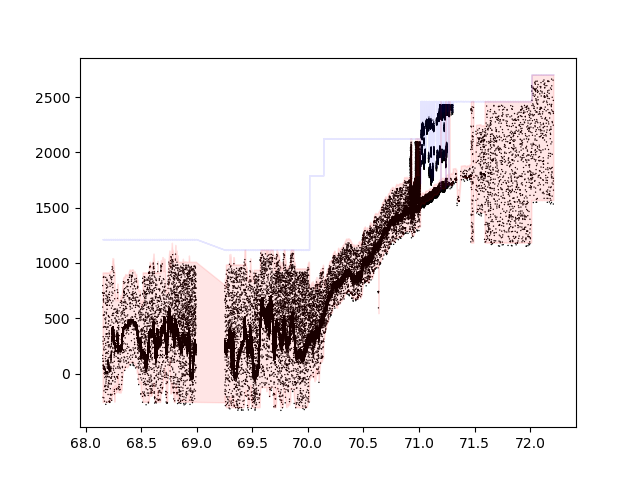

In [324]:
plt.close('all')

gtx = 'gt3r'
df = dfs[gtx]
dft = dfs_tlm[gtx]

mframe_group = df.groupby('mframe')
df_mframe = mframe_group[['lat','lon', 'xatc', 'dt']].mean()
df_mframe = df_mframe.join(dft, how='left')
fig, ax = plt.subplots()
ax.scatter(df.lat, df.h, s=1, color='k', edgecolors='none',alpha=1)

# df_mframe.loc[df_mframe.tlm_height_band1==0, 'tlm_height_band1'] = np.nan
# df_mframe.loc[df_mframe.tlm_height_band2==0, 'tlm_height_band2'] = np.nan

ax.fill_between(df_mframe.lat, df_mframe.tlm_top_band1 - df_mframe.tlm_height_band1, df_mframe.tlm_top_band1, color='r', alpha=0.1)
ax.fill_between(df_mframe.lat, df_mframe.tlm_top_band2 - df_mframe.tlm_height_band2, df_mframe.tlm_top_band2, color='b', alpha=0.1)

In [309]:
df_mframe

,lat,lon,xatc,dt,tlm_height_band1,tlm_height_band2,tlm_top_band1,tlm_top_band2
mframe,,,,,,,,
3466011192,72.186759,-49.027416,1.201675e+07,1.166561e+08,0.0,1040.279907,2872.961670,2873.031738
3466011194,72.184185,-49.028555,1.201704e+07,1.166561e+08,0.0,1040.279907,2872.637451,2872.707520
3466011196,72.181692,-49.029633,1.201733e+07,1.166561e+08,0.0,1040.279907,2872.304688,2872.374756
3466011197,72.180089,-49.030421,1.201751e+07,1.166561e+08,0.0,1043.277710,2872.142822,2872.212891
3466011198,72.178524,-49.031047,1.201768e+07,1.166561e+08,0.0,1043.277710,2871.978271,2872.048340
...,...,...,...,...,...,...,...,...
3466014397,68.139145,-50.552342,1.247158e+07,1.166562e+08,0.0,1169.190674,1193.034180,890.218872
3466014398,68.138573,-50.552520,1.247196e+07,1.166562e+08,0.0,1169.190674,1192.839722,890.024292
3466014399,68.137550,-50.552799,1.247198e+07,1.166562e+08,0.0,1169.190674,1192.643188,889.827759


In [296]:
print(np.sum(valid), len(valid))

17427 21357


In [297]:
valid

array([ True,  True,  True, ..., False, False, False])

In [300]:
ph_index_beg[:30]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1,
       -1, -1, -1, -1, 15, -1, -1, -1, -1, -1, -1, 16, -1])

In [302]:
dfs_tlm.keys()

dict_keys(['gt1l', 'gt1r', 'gt2l', 'gt2r', 'gt3l', 'gt3r'])

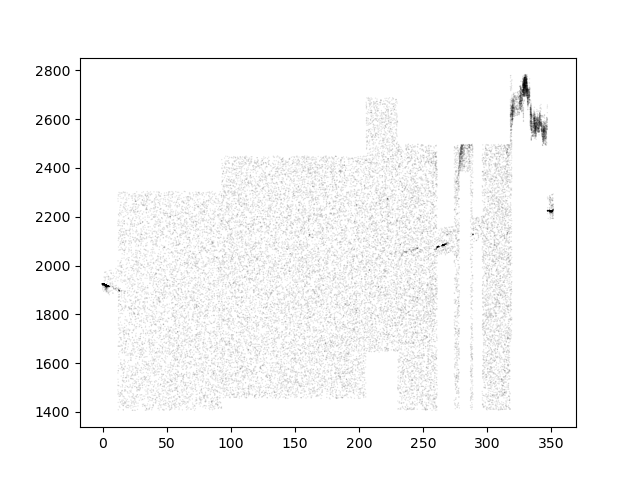

In [292]:
fig, ax = plt.subplots()
ax.scatter((df.xatc-df.xatc.min())/1000, df.h, s=1, color='k', edgecolors='none',alpha=0.1)

### Print some commands for testing

In [217]:
for i in range(5):
    print(df_all.granule_url.iloc[i], df_all.size_mb.iloc[i])

https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264219955/processed_ATL03_20190916150733_12300405_006_02.h5 1209.51
https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264220959/processed_ATL03_20190908023918_11000403_006_02.h5 9.26
https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264221961/processed_ATL03_20190920145914_12910405_006_02.h5 630.88
https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264222972/processed_ATL03_20190904153231_10470405_006_02.h5 246.47
https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264223036/processed_ATL03_20190920021420_12830403_006_02.h5 267.98


In [218]:
tofind = 'ATL03_20230806063138_07192003_006_02.h5'
tofind = 'ATL03_20220714010847_03381603_006_02.h5'
tofind = 'ATL03_20190716051841_02770403_006_02.h5'
dftesting = df_all[df_all.apply(lambda x: tofind in x.granule, axis=1)]
for i in list(dftesting.index):
    granule = dftesting.loc[i, 'granule']
    polygon = dftesting.loc[i, 'polygon'] 
    print('python3 detect_lakes.py --granule %s --polygon %s' % (granule, polygon))

python3 detect_lakes.py --granule https://n5eil02u.ecs.nsidc.org/esir/5000005624133/267711339/processed_ATL03_20190716051841_02770403_006_02.h5 --polygon geojsons/simplified_GRE_2200_CW.geojson


In [164]:
granule_url = df_all.granule.iloc[0]
print(granule_url)

is2_data_dir = 'IS2data'
filename = granule_url.split('/')[-1]
input_filename = is2_data_dir + '/' + filename

uid = decedc(edc().u)
pwd = decedc(edc().p)
capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pwd))
response = session.get(granule_url)
request_status_code = response.status_code

if request_status_code == 200:
    print('Downloading file...')
    with open(input_filename, 'wb') as file:
        file.write(response.content)
    print('NSIDC API request was successful!')
    del response
else:
    print('\nNSIDC API request failed. (Request status code: %i)' % request_status_code)

https://n5eil02u.ecs.nsidc.org/esir/5000005624133/264219955/processed_ATL03_20190916150733_12300405_006_02.h5
NSIDC API request was successful!


In [169]:
del response

NameError: name 'response' is not defined

In [125]:
df = pd.read_csv(fn_order_info_progress)

# #### to get the credentials into the session
# uid = decedc(edc().u)
# pwd = decedc(edc().p)
# capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/ATL03.006.xml'
# session = requests.session()
# s = session.get(capability_url)
# response = session.get(s.url,auth=(uid,pwd))

for i in list(df.index)[:2]:
    gran_list_url = df.loc[i, 'gran_list_url']
    gran_list_file = session.get(gran_list_url)
    status_txt = int(gran_list_file.status_code)
    gran_list = gran_list_file.content.decode('utf-8').split('\n')
    gran_list = [x for x in gran_list if '.h5' in x]

In [126]:
gran_list

['https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264300477/processed_ATL03_20200926205605_00410905_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264300895/processed_ATL03_20200901221141_10470805_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264301204/processed_ATL03_20200914212103_12450805_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264301291/processed_ATL03_20200925212145_00260905_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264301424/processed_ATL03_20200913090149_12220803_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264302089/processed_ATL03_20200929211324_00870905_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264303207/processed_ATL03_20200909091009_11610803_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264303211/processed_ATL03_20200922081931_13590803_006_02.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000005624134/264303413/processed_ATL03_2020091708

In [ ]:
shape = 'geojsons/teslake_gris_bounding_box.geojson'
start_date = '2019-05-01'
end_date = '2021-05-01'


short_name='ATL03'
start_time='00:00:00'
end_time='23:59:59'
rgt='all'
gtxs='all'
uid=None
pwd=None
boundbox=None
vars_sub='default'

In [ ]:
request_response.content

In [ ]:
statusURL

In [ ]:
https://n5eil02u.ecs.nsidc.org/esir/5000005624099.txt

In [ ]:
status_URLs = [statusURL]

In [ ]:
statuslist = []
for status in request_root.findall("./requestStatus/"):
    statuslist.append(status.text)
status = statuslist[0]
print('Data request ', page_val, ' is submitting...')
print('Initial request status is ', status)

In [ ]:
statuslist = []
for status in request_root.findall("./requestStatus/"):
    statuslist.append(status.text)
statuslist